In [1]:
%cd "F:\University\Master's Thesis\Datasets\rnd"

F:\University\Master's Thesis\Datasets\rnd


In [24]:
%pip install "u8darts[notorch]"


     ---------------------------------------- 0.0/49.9 kB ? eta -:--:--
     ---------------------------------------- 49.9/49.9 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     ---------------------------------------- 47.0/47.0 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.6/101.0 MB 13.1 MB/s eta 0:00:08
   ---------------------------------------- 1.0/101.0 MB 13.3 MB/s eta 0:00:08
   ---------------------------------------- 1.0/101.0 MB 13.3 MB/s eta 0:00:08
   ---------------------------------------- 1.0/101.0 MB 13.3 MB/s eta 0:00:08
   ---------------------------------------- 1.0/101.0 MB 13.3 MB/s eta 0:00:08
   ---------------------------------------- 1.0/101.0 MB 13.3 MB/s eta 0:00:08
   ---------------------------------------- 1.0/101.0 MB 13.3 MB/s eta 0:00:08
   ---------------------------------------- 1.0/101.0 MB 13.3 MB/s eta 

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import numpy as np
import pandas as pd
import shutil

from darts import TimeSeries
from darts.models import NHiTSModel, TiDEModel, TCNModel, BlockRNNModel
from darts.dataprocessing.transformers.scaler import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.metrics import mae, mse

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

F:\Software\Anaconda\envs\deeplearning-env\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 6.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [16]:
import copy
from pathlib import Path

# List of columns you want to read
selected_columns = ["Time", "Memory"]

file_path = 'CPU & Memory Data Interpolated.csv'
df = pd.read_csv(file_path, usecols=selected_columns)
df.head(-1)

Time    CPU
0      4/19/2024 16:22  0.980
1      4/19/2024 16:23  0.885
2      4/19/2024 16:24  0.740
3      4/19/2024 16:25  0.609
4      4/19/2024 16:26  0.447
...                ...    ...
35328   5/14/2024 5:10  0.276
35329   5/14/2024 5:11  0.276
35330   5/14/2024 5:12  0.281
35331   5/14/2024 5:13  0.284
35332   5/14/2024 5:14  0.283

[35333 rows x 2 columns]

In [17]:
# Convert 'Timestamp [ms]' to datetime and set it as the index
df.set_index('Time', inplace=True)

# Specify the frequency of your time series (e.g., 'H' for hourly, 'D' for daily)
frequency = 'm'  # Replace 'your_frequency' with the appropriate frequency code

# Preserve the 'Timestamp [ms]' column
df['Time'] = df.index

In [19]:
# Create a Darts TimeSeries object
series = TimeSeries.from_dataframe(df, "Time", 'Memory')

# Assuming 'series' is your TimeSeries object
train_size = int(len(series) * 0.1)  # Halve the training set

# Split the data
# series = series[:train_size]

print(len(series))

35334


In [20]:
train, temp = series.split_after(0.7)
val, test = temp.split_after(0.5)

plt.figure(figsize=(24, 6))
train.plot(label="train")
val.plot(label="val")
test.plot(label="test")
plt.title("Memory Trend")
plt.xlabel("Time")
plt.ylabel("Value")

# Show legend
plt.legend()

plt.savefig("Memory_Trend.png")

<Axes: xlabel='Time'>

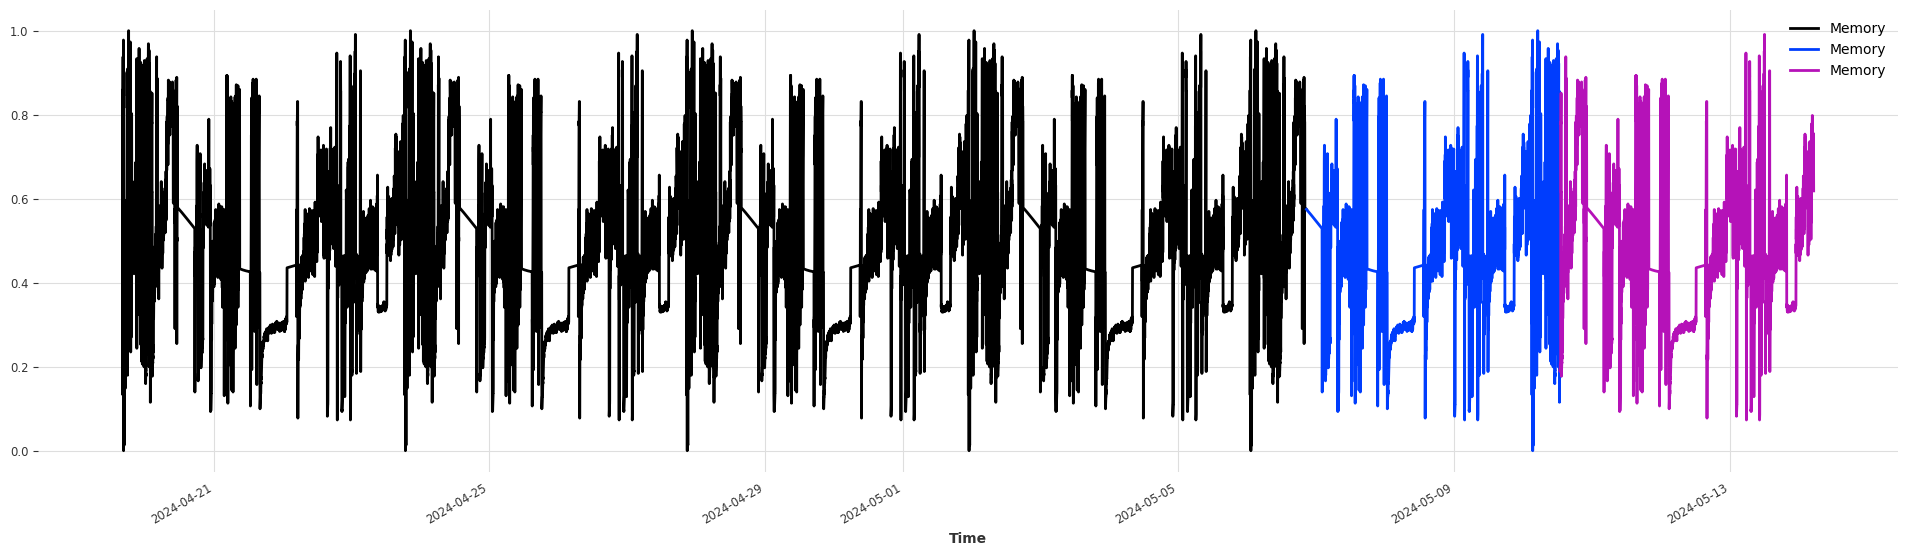

In [8]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

scaler = Scaler()  # default uses sklearn's MinMaxScaler
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

plt.figure(figsize=(24, 6))
train.plot()
val.plot()
test.plot()

In [9]:
# Common parameters
common_model_args = {
    "input_chunk_length": 2880,
    "output_chunk_length": 1440,
    "optimizer_kwargs": {"lr": 1e-3},
    "pl_trainer_kwargs": {
        "gradient_clip_val": 1,
        "max_epochs": 40,
        "accelerator": "auto",
        "callbacks": [],
        "logger": None
    },
    "lr_scheduler_cls": torch.optim.lr_scheduler.ExponentialLR,
    "lr_scheduler_kwargs": {"gamma": 0.999},
    "likelihood": None,
    "save_checkpoints": True,
    "force_reset": True,
    "batch_size": 128,
    "random_state": 42,
}

# Define early stopping arguments
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 3,
    "mode": "min",
    "strict": True,
    "verbose": True,
}

# Update your pl_trainer_kwargs
pl_trainer_kwargs = common_model_args["pl_trainer_kwargs"]

# Model-specific parameters
model_nhits_params = {
    "model_name": "nhits_memory",
}

model_tide_params = {
    "model_name": "tide_memory",
    "use_reversible_instance_norm": False,
}


model_tcn_params = {
    "model_name": "tcn_memory",
}

model_lstm_params = {
    "model_name": "lstm_memory",
    "model": "LSTM",
    "n_rnn_layers": 4
}

# Define each model by merging common and model-specific parameters
model_nhits_memory = NHiTSModel(**common_model_args, **model_nhits_params)
model_tide_memory = TiDEModel(**common_model_args, **model_tide_params)
model_tcn_memory = TCNModel(**common_model_args, **model_tcn_params)
model_lstm_memory = BlockRNNModel(**common_model_args, **model_lstm_params)


models = {
    "NHiTS": model_nhits_memory,
    "TiDE": model_tide_memory,
    #"TCN": model_tcn_memory,
    #"LSTM": model_lstm_memory
}

In [10]:
# Saving the model to disk
import pickle

# Set the log directory where logs will be saved
log_dir = "logs"

# Create a TensorBoardLogger
logger = TensorBoardLogger(log_dir, name="microservices_all_models")

# Update your pl_trainer_kwargs
pl_trainer_kwargs["logger"] = logger

# Train the models and load the model from its best state/checkpoint
for name, model in models.items():
    # early stopping needs to get reset for each model
    pl_trainer_kwargs["callbacks"] = [
        EarlyStopping(
            **early_stopping_args,
        )
    ]

    # Use the logger in the Trainer (remove 'logger' from Trainer arguments)
    pl_trainer = pl.Trainer(**pl_trainer_kwargs)

    model.fit(
        series=train,
        val_series=val,
        verbose=True,
    )
    # load from checkpoint returns a new model object, we store it in the models dict
    models[name] = model.load_from_checkpoint(model_name=model.model_name, best=True)
    model.save(f"models/{name}_microservices_memory.pt")




Sanity Checking: |                                               | 0/? [00:00<?, ?it/s]

Training: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Sanity Checking: |                                               | 0/? [00:00<?, ?it/s]

Training: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Predicting: |                                                    | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Time'>

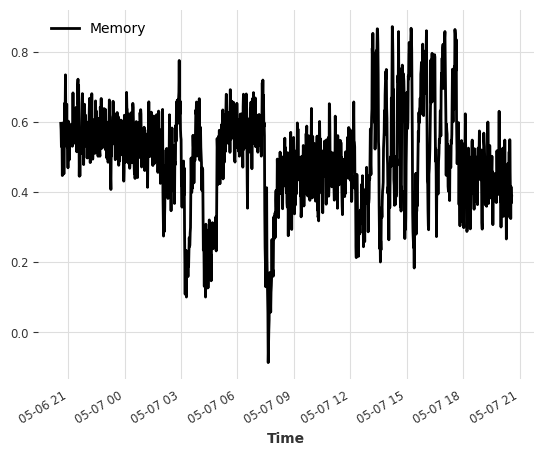

In [10]:
model_nhits_memory = NHiTSModel.load('models/NHiTS_microservices_memory.pt')
# model_tcn_memory = TCNModel.load('models/TCN_microservices_memory.pt')
model_tide_memory = TiDEModel.load('models/TiDE_microservices_memory.pt')
pred = model_tide_memory.predict(1440)
pred.plot()

Predicting: |                                                    | 0/? [00:00<?, ?it/s]

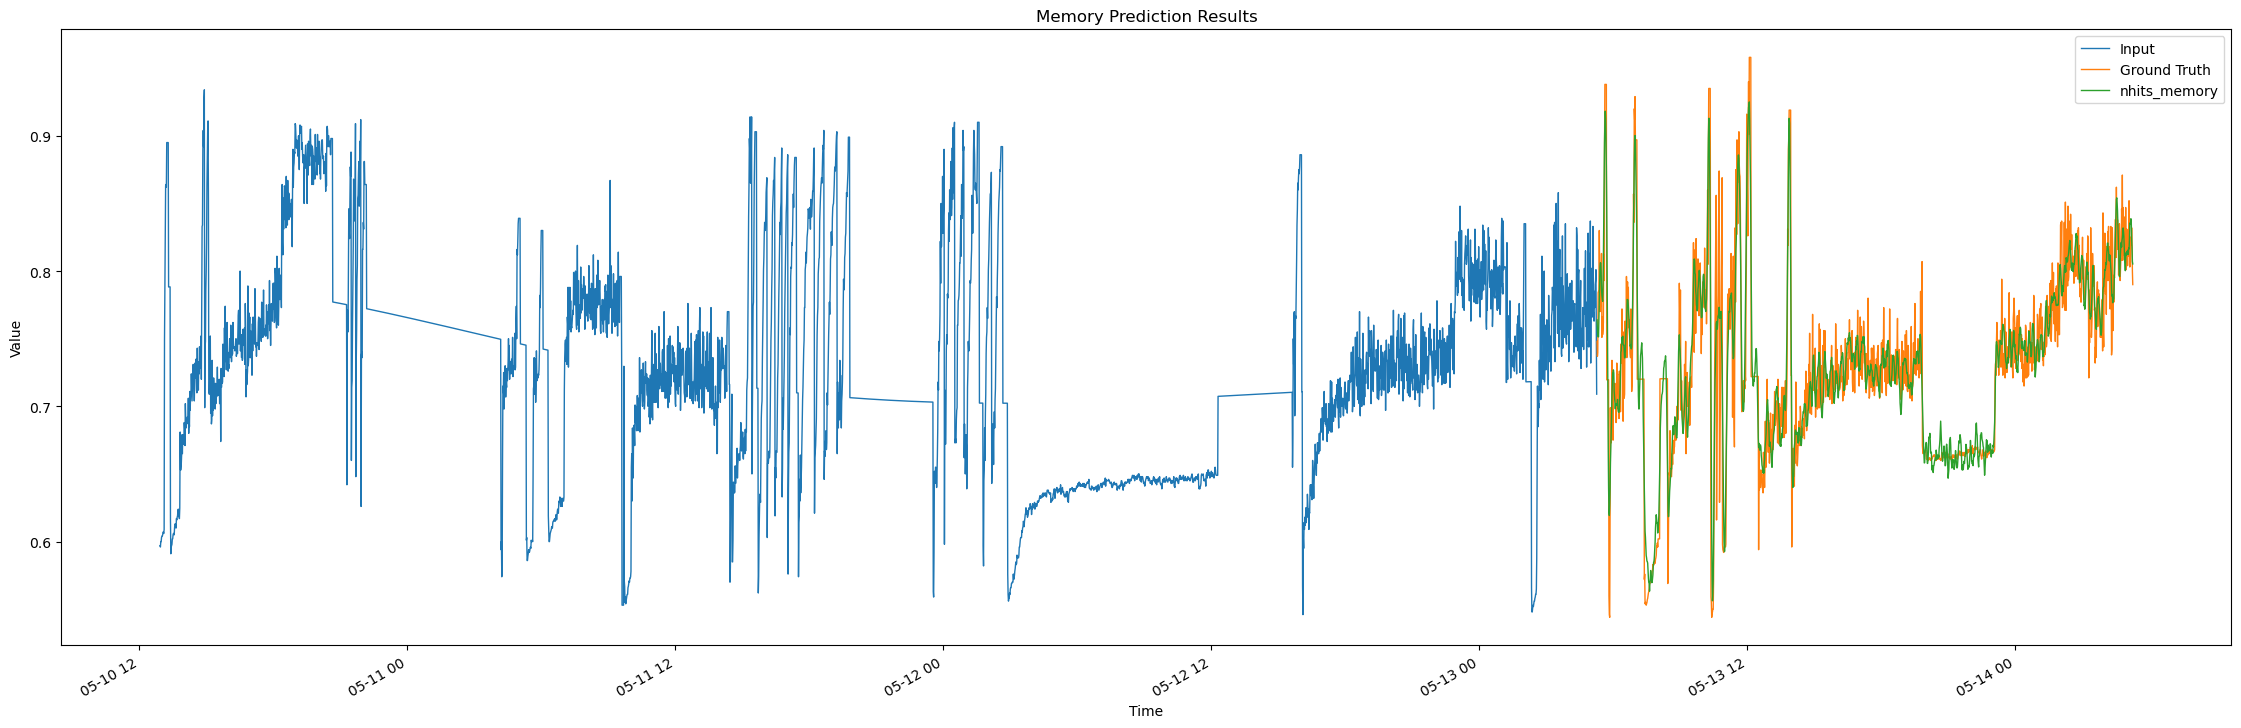

In [12]:
from darts.metrics import quantile_loss
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)

# we will predict the next `pred_steps` points after the end of `pred_input`
pred_steps = common_model_args["output_chunk_length"]
pred_input = test[:-pred_steps]

fig, ax = plt.subplots(figsize=(28, 8))
# plt.xlim(start_date, end_date)

# Plot the input data
scaler.inverse_transform(pred_input).plot(label="Input", linewidth=1)

# Plot the ground truth data
scaler.inverse_transform(test)[-pred_steps:].plot(label="Ground Truth", linewidth=1)

result_accumulator = {}
# predict with each model and compute/store the metrics against the test sets
# for model_name, model in models.items():
pred_series = model_nhits_memory.predict(n=pred_steps, series=pred_input)
scaler.inverse_transform(pred_series).plot(label='nhits_memory', ax=ax, linewidth=1)

# Set title and labels
plt.title("Memory Prediction Results")
plt.xlabel("Time")
plt.ylabel("Value")

# Show legend
plt.legend()

plt.savefig("memory_microservices_prediction.png")

# Show plot
plt.show()

    # result_accumulator[model_name] = {
    #     "mae": mae(test, pred_series),
    #     "mse": mse(test, pred_series)
    # }

In [14]:
mae_memory = mae(test, pred_series)
mse_memory = mse(test, pred_series)
print(mae_memory, mse_memory)

0.037998010316060156 0.003013278539222117


In [17]:
pred_df = pred_series.pd_dataframe()

In [18]:
pred_df.head(-1)

component              Memory
Time                         
2024-05-13 05:16:00  0.534445
2024-05-13 05:17:00  0.498236
2024-05-13 05:18:00  0.499383
2024-05-13 05:19:00  0.570122
2024-05-13 05:20:00  0.673267
...                       ...
2024-05-14 05:10:00  0.566785
2024-05-14 05:11:00  0.509043
2024-05-14 05:12:00  0.611153
2024-05-14 05:13:00  0.646864
2024-05-14 05:14:00  0.609269

[1439 rows x 1 columns]